<a href="https://colab.research.google.com/github/amadousysada/image-segmentation/blob/main/p8_01_exploration_and_features_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

## Import des librairies

In [63]:
import time
init_time = time.time()

import os

import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

print("Versions:")
print(f"{' '*2}- Numpy        =>: {np.__version__}")
print(f"{' '*2}- tensorflow   =>: {tf.__version__}")
print(f"{' '*2}- keras        =>: {tf.keras.__version__}")
print(f"{' '*2}- matplotlib   =>: {plt.matplotlib.__version__}")

Versions:
  - Numpy        =>: 2.0.2
  - tensorflow   =>: 2.18.0
  - keras        =>: 3.8.0
  - matplotlib   =>: 3.10.0


In [22]:
base_path = "/content/drive/MyDrive/data/"
image_dir = os.path.join(base_path, "leftImg8bit")
mask_dir = os.path.join(base_path, "gtFine")

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Exploration

In [64]:
# Mapping des groupes vers la liste des classes Cityscapes correspondantes
"""
Sources:
  - https://raw.githubusercontent.com/mcordts/cityscapesScripts/master/cityscapesscripts/helpers/labels.py
  - https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py
  - https://datasetninja.com/cityscapes
  - https://github.com/mcordts/cityscapesScripts
"""
CLASS_GROUPS = {
    "flat":        ["road", "sidewalk", "parking", "rail track"],
    "human":       ["person", "rider"],
    "vehicle":     ["car", "truck", "bus", "on rails", "motorcycle", "bicycle", "caravan", "trailer"],
    "construction":["building", "wall", "fence", "guard rail", "bridge", "tunnel"],
    "object":      ["pole", "pole group", "traffic sign", "traffic light"],
    "nature":      ["vegetation", "terrain"],
    "sky":         ["sky"],
    "void":        ["unlabeled", "ego vehicle", "ground", "rectification border", "out of roi", "dynamic", "static"]
}

GROUP_PALETTE = [
    (128, 64, 128),    # 0 - flat
    (220, 20, 60),     # 1 - human
    (0, 0, 142),       # 2 - vehicle
    (70, 70, 70),      # 3 - construction
    (220, 220, 0),     # 4 - object
    (107, 142, 35),    # 5 - nature
    (70, 130, 180),    # 6 - sky
    (0, 0, 0),         # 7 - void
]

group_cmap = ListedColormap(np.array(GROUP_PALETTE) / 255.0)

ordered_groups = list(CLASS_GROUPS.keys())

LABEL_ID_TO_NAME = {
    0: "unlabeled",
    1: "ego vehicle",
    2: "rectification border",
    3: "out of roi",
    4: "static",
    5: "dynamic",
    6: "ground",
    7: "road",
    8: "sidewalk",
    9: "parking",
    10: "rail track",
    11: "building",
    12: "wall",
    13: "fence",
    14: "guard rail",
    15: "bridge",
    16: "tunnel",
    17: "pole",
    18: "pole group",
    19: "traffic light",
    20: "traffic sign",
    21: "vegetation",
    22: "terrain",
    23: "sky",
    24: "person",
    25: "rider",
    26: "car",
    27: "truck",
    28: "bus",
    29: "caravan",
    30: "trailer",
    31: "on rails",
    32: "motorcycle",
    33: "bicycle",
}

NAME_TO_LABEL_ID = {v: k for k, v in sorted(LABEL_ID_TO_NAME.items())}

CLASS_MAP = {}
for group_idx, group_name in enumerate(ordered_groups):
    for class_name in CLASS_GROUPS[group_name]:
        cid = NAME_TO_LABEL_ID.get(class_name, -1)
        CLASS_MAP[cid] = group_idx


mapping = [7] * 34   # initialisé à 7 (void)
for orig_id, new_id in CLASS_MAP.items():
    mapping[orig_id] = new_id

In [69]:
tf.constant(mapping, dtype=tf.int32)

<tf.Tensor: shape=(34,), dtype=int32, numpy=
array([7, 7, 7, 7, 7, 7, 7, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5,
       5, 6, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)>

In [25]:
def augment_data(image, mask):
    # flip horizontal aléatoire
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask  = tf.image.flip_left_right(mask[..., tf.newaxis])[..., 0]
    # légère variation de contraste
    image = tf.image.random_contrast(image, 0.8, 1.2)
    # légère variation de luminosité
    image = tf.image.random_brightness(image, 0.1)
    return image, mask


def build_dataset(img_paths, mask_paths, image_size=(224, 224), data_type="train", batch_size=32, validation_split=0.3, augment=False, shuffle=False):
  ds = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))

  def _load(i, m):
    img = tf.image.decode_png(tf.io.read_file(i), channels=3)
    mask = tf.image.decode_png(tf.io.read_file(m), channels=1)
    img = tf.image.resize(img, image_size, method=tf.image.ResizeMethod.BILINEAR)
    img = tf.cast(img, tf.float32) / 255.0

    mask = tf.image.resize(mask, image_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    mask = tf.cast(mask, tf.int32)

    mask = tf.gather(tf.constant(mapping, dtype=tf.int32), mask)

    return img, mask

  ds = ds.map(_load, num_parallel_calls=tf.data.AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(buffer_size=1024)

  if augment:
    ds = ds.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)

  ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

  return ds

def make_dataset(image_size=(224, 224), data_type="train", batch_size=32, validation_split=0.0, augment=False, shuffle=False):
  images_path = []
  masks_path = []

  for city in os.listdir(f"{image_dir}/{data_type}"):
    image_path = os.path.join(image_dir, data_type, city)
    mask_path = os.path.join(mask_dir, data_type, city)
    for image in os.listdir(image_path):
      if image.endswith("_leftImg8bit.png"):
        base = image.replace("_leftImg8bit.png", "")
        mask = base + "_gtFine_labelIds.png"
        if os.path.exists(os.path.join(mask_path, mask)):
          images_path.append(os.path.join(image_path, image))
          masks_path.append(os.path.join(mask_path, mask))

  if data_type == "train" and validation_split > 0:
      n = len(images_path)
      split_idx = int((1 - validation_split) * n)
      train_imgs, val_imgs = images_path[:split_idx], images_path[split_idx:]
      train_msks, val_msks = masks_path[:split_idx], masks_path[split_idx:]

      train_ds = build_dataset(train_imgs, train_msks, image_size, batch_size, shuffle=shuffle, augment=augment)
      val_ds   = build_dataset(val_imgs, val_msks, image_size, batch_size)
      return train_ds, val_ds
  else:
      return build_dataset(images_path, masks_path, image_size, batch_size, shuffle=shuffle, augment=augment)

In [26]:
def plot_sample(ds, figsize=(14, 6), title=""):
  for imgs, masks in ds.take(1):
    idx = np.random.choice(range(0,32))
    img = imgs[idx]
    mask = masks[idx]

    plt.figure(figsize=figsize)
    ax= plt.subplot(1, 3, 1)
    ax.imshow(img)
    plt.title("Image")
    plt.axis("off")

    ax = plt.subplot(1, 3, 2)
    ax.imshow(mask)
    plt.title("Mask")
    plt.axis("off")

    ax = plt.subplot(1, 3, 3)
    mask_arr = mask.numpy()
    unique_classes, counts = np.unique(mask_arr, return_counts=True)
    percentages = counts / mask_arr.size * 100
    group_names = [ordered_groups[i] for i in unique_classes]

    ax.pie(percentages, labels=group_names, autopct="%1.1f%%", startangle=90)
    ax.set_title("Répartition des groupes dans le mask")
    plt.axis("equal")
    plt.suptitle("Test de l'echantillon train", fontsize=16)
    plt.show()

In [54]:
%%time
train_ds = make_dataset(data_type="train", batch_size=32, augment=True)
validation_ds = make_dataset(data_type="val", batch_size=32)
test_ds = make_dataset(data_type="test", batch_size=32)

CPU times: user 237 ms, sys: 144 ms, total: 381 ms
Wall time: 15.7 s


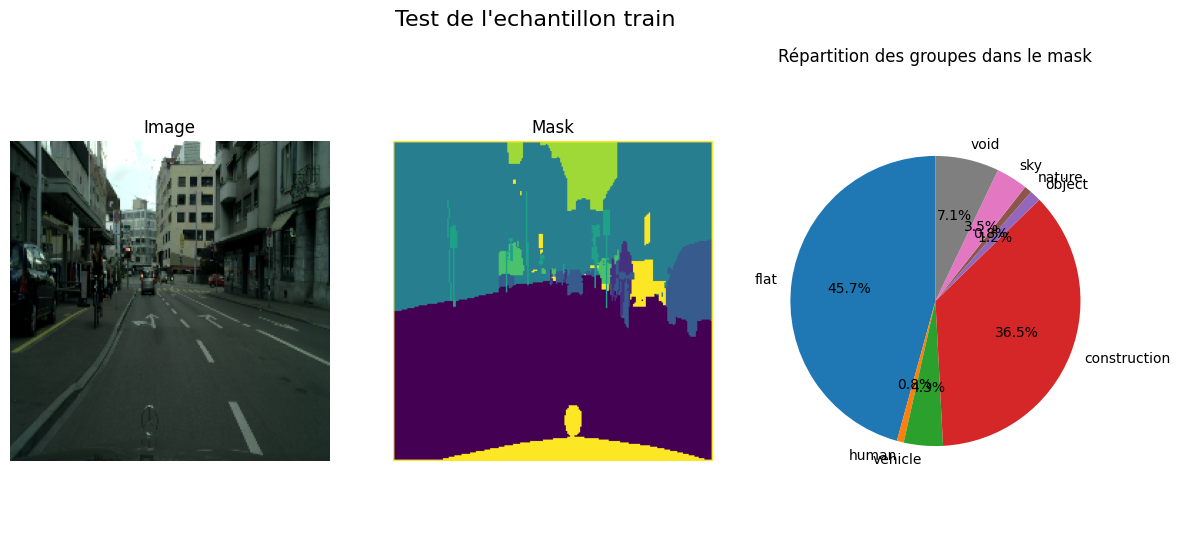

CPU times: user 4.39 s, sys: 88.4 ms, total: 4.48 s
Wall time: 900 ms


In [28]:
%%time
plot_sample(train_ds, title="Test de l'echantillon train")

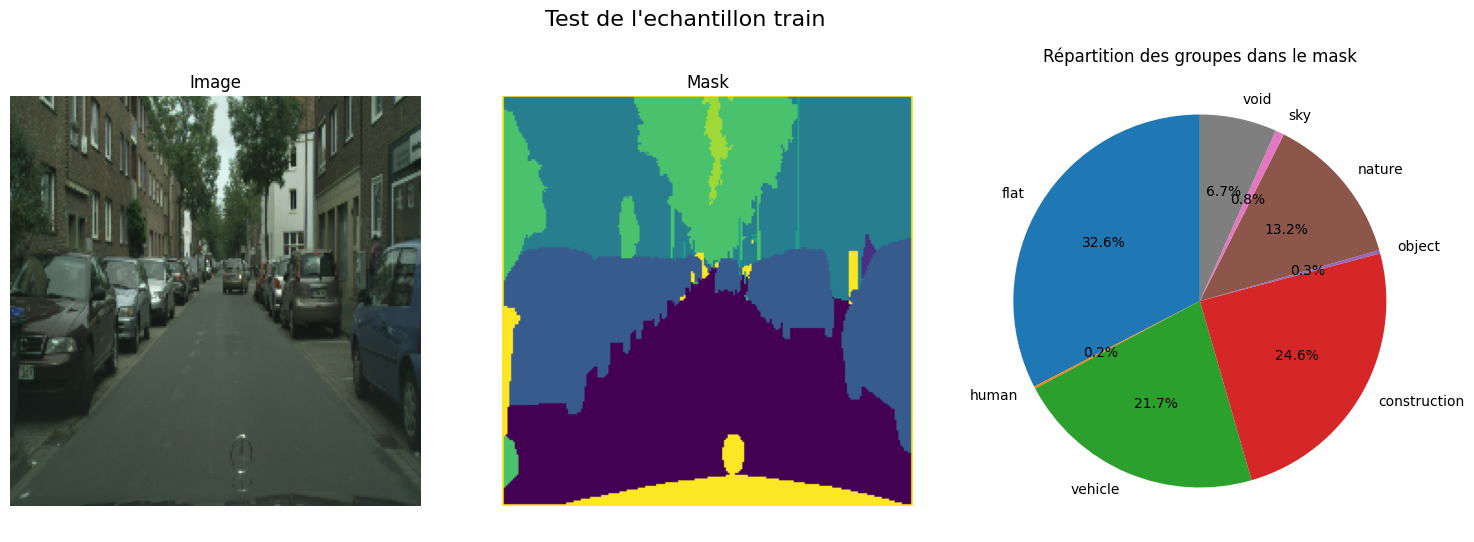

CPU times: user 4.52 s, sys: 90.5 ms, total: 4.61 s
Wall time: 778 ms


In [29]:
%%time
plot_sample(validation_ds, title="Test de l'echantillon validation", figsize=(18, 6))

AFFICHER LES LABELS par COULEURS

# Modélisation

### Metrics & Loss functions

**Metrcis**:
* MeanIoU
* Accuracy

In [30]:
class MeanIoUArgmax(tf.keras.metrics.MeanIoU):
    """Custom MeanIoU metric that applies argmax to predictions"""
    def update_state(self, y_true, y_pred, sample_weight=None):
        # y_pred : (batch, H, W, num_classes) → take the winning class
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)



**Loss functions:**
* Dice Loss
* Focal Loss
* Combined Loss
* balanced_cross_entropy

In [31]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    """
    Dice Loss for semantic segmentation

    Args:
        y_true: Ground truth masks (batch_size, H, W)
        y_pred: Predicted logits (batch_size, H, W, num_classes)
        smooth: Smoothing factor to avoid division by zero

    Returns:
        Dice loss value
    """
    # Convert predictions to probabilities
    y_pred = tf.nn.softmax(y_pred, axis=-1)

    # Convert ground truth to one-hot encoding
    num_classes = tf.shape(y_pred)[-1]
    y_true_one_hot = tf.one_hot(y_true, depth=num_classes)

    # Flatten tensors
    y_true_flat = tf.reshape(y_true_one_hot, [-1, num_classes])
    y_pred_flat = tf.reshape(y_pred, [-1, num_classes])

    # Calculate Dice coefficient for each class
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat, axis=0)
    union = tf.reduce_sum(y_true_flat, axis=0) + tf.reduce_sum(y_pred_flat, axis=0)

    dice_coeff = (2. * intersection + smooth) / (union + smooth)

    # Return 1 - mean Dice coefficient as loss
    return 1 - tf.reduce_mean(dice_coeff)


def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    """
    Focal Loss for addressing class imbalance

    Args:
        y_true: Ground truth masks (batch_size, H, W)
        y_pred: Predicted logits (batch_size, H, W, num_classes)
        alpha: Weighting factor for rare class
        gamma: Focusing parameter

    Returns:
        Focal loss value
    """
    # Convert to probabilities
    y_pred = tf.nn.softmax(y_pred, axis=-1)

    # Convert ground truth to one-hot encoding
    num_classes = tf.shape(y_pred)[-1]
    y_true_one_hot = tf.one_hot(y_true, depth=num_classes)

    # Calculate cross entropy
    ce_loss = -y_true_one_hot * tf.math.log(tf.clip_by_value(y_pred, 1e-8, 1.0))

    # Calculate focal weight
    p_t = y_true_one_hot * y_pred
    alpha_t = y_true_one_hot * alpha
    focal_weight = alpha_t * tf.pow(1 - p_t, gamma)

    # Apply focal weight
    focal_loss = focal_weight * ce_loss

    return tf.reduce_mean(tf.reduce_sum(focal_loss, axis=-1))


def combined_loss(y_true, y_pred, dice_weight=0.5, ce_weight=0.5):
    """
    Combined Dice + Cross-Entropy Loss

    Args:
        y_true: Ground truth masks
        y_pred: Predicted logits
        dice_weight: Weight for dice loss
        ce_weight: Weight for cross-entropy loss

    Returns:
        Combined loss value
    """
    dice = dice_loss(y_true, y_pred)
    ce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)
    ce = tf.reduce_mean(ce)

    return dice_weight * dice + ce_weight * ce


def balanced_cross_entropy(y_true, y_pred, class_weights=None):
    """
    Balanced Cross-Entropy Loss with class weights

    Args:
        y_true: Ground truth masks
        y_pred: Predicted logits
        class_weights: Optional class weights tensor

    Returns:
        Weighted cross-entropy loss
    """
    if class_weights is None:
        # Default weights for Cityscapes (8 classes)
        class_weights = tf.constant([0.5, 2.0, 2.0, 1.0, 1.5, 3.0, 1.0, 0.1])

    # Convert to probabilities
    y_pred = tf.nn.softmax(y_pred, axis=-1)

    # Convert ground truth to one-hot
    num_classes = tf.shape(y_pred)[-1]
    y_true_one_hot = tf.one_hot(y_true, depth=num_classes)

    # Calculate weighted cross entropy
    ce_loss = -y_true_one_hot * tf.math.log(tf.clip_by_value(y_pred, 1e-8, 1.0))
    weighted_ce = ce_loss * class_weights

    return tf.reduce_mean(tf.reduce_sum(weighted_ce, axis=-1))

### Architecture

In [32]:
def conv_block(x, filters, kernel_size=3, activation='relu', batch_norm=True):
    """Basic convolutional block with optional batch normalization"""
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    return x


def encoder_block(x, filters, pool_size=2):
    """Encoder block for U-Net: conv + conv + maxpool"""
    skip = conv_block(x, filters)
    skip = conv_block(skip, filters)
    x = layers.MaxPooling2D(pool_size)(skip)
    return x, skip


def decoder_block(x, skip, filters):
    """Decoder block for U-Net: upsample + concat + conv + conv"""
    x = layers.Conv2DTranspose(filters, 2, strides=2, padding='same')(x)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    x = conv_block(x, filters)
    return x


def unet_mini(input_shape=(224, 224, 3), num_classes=8, filters_base=32):
    """
    Mini U-Net model (non-pretrained baseline)

    Args:
        input_shape: Input image shape
        num_classes: Number of segmentation classes
        filters_base: Base number of filters

    Returns:
        Keras Model
    """
    inputs = layers.Input(input_shape)

    # Encoder
    x1, skip1 = encoder_block(inputs, filters_base)      # 224x224 → 112x112
    x2, skip2 = encoder_block(x1, filters_base * 2)      # 112x112 → 56x56
    x3, skip3 = encoder_block(x2, filters_base * 4)      # 56x56 → 28x28

    # Bottleneck
    bottleneck = conv_block(x3, filters_base * 8)       # 28x28
    bottleneck = conv_block(bottleneck, filters_base * 8)

    # Decoder
    d1 = decoder_block(bottleneck, skip3, filters_base * 4)  # 28x28 → 56x56
    d2 = decoder_block(d1, skip2, filters_base * 2)          # 56x56 → 112x112
    d3 = decoder_block(d2, skip1, filters_base)              # 112x112 → 224x224

    # Final upsampling and classification
    #d4 = layers.Conv2DTranspose(filters_base, 2, strides=2, padding='same')(d3)  # 224x224
    outputs = layers.Conv2D(num_classes, 1, activation='softmax', name='segmentation_output')(d3)

    model = Model(inputs, outputs, name='UNet_Mini')
    return model


def vgg16_unet(input_shape=(224, 224, 3), num_classes=8, freeze_encoder=False):
    """
    U-Net with VGG16 pretrained backbone

    Args:
        input_shape: Input image shape
        num_classes: Number of segmentation classes
        freeze_encoder: Whether to freeze the encoder weights

    Returns:
        Keras Model
    """
    # Load pretrained VGG16 as encoder
    vgg16 = tf.keras.applications.VGG16(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False
    )

    if freeze_encoder:
        vgg16.trainable = False

    # Extract skip connections from VGG16
    skip1 = vgg16.get_layer('block1_conv2').output    # 224x224, 64
    skip2 = vgg16.get_layer('block2_conv2').output    # 112x112, 128
    skip3 = vgg16.get_layer('block3_conv3').output    # 56x56, 256
    skip4 = vgg16.get_layer('block4_conv3').output    # 28x28, 512

    # Bottleneck (center of U-Net)
    bottleneck = vgg16.get_layer('block5_conv3').output  # 14x14, 512
    x = conv_block(bottleneck, 1024)
    x = conv_block(x, 1024)

    # Decoder with skip connections
    # Upsample and concatenate with skip4
    x = layers.Conv2DTranspose(512, 2, strides=2, padding='same')(x)  # 28x28
    x = layers.Concatenate()([x, skip4])
    x = conv_block(x, 512)
    x = conv_block(x, 512)

    # Upsample and concatenate with skip3
    x = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(x)  # 56x56
    x = layers.Concatenate()([x, skip3])
    x = conv_block(x, 256)
    x = conv_block(x, 256)

    # Upsample and concatenate with skip2
    x = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(x)  # 112x112
    x = layers.Concatenate()([x, skip2])
    x = conv_block(x, 128)
    x = conv_block(x, 128)

    # Upsample and concatenate with skip1
    x = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(x)   # 224x224
    x = layers.Concatenate()([x, skip1])
    x = conv_block(x, 64)
    x = conv_block(x, 64)

    # Final classification layer
    outputs = layers.Conv2D(num_classes, 1, activation='softmax', name='segmentation_output')(x)

    model = Model(vgg16.input, outputs, name='VGG16_UNet')
    return model


def resnet50_unet(input_shape=(224, 224, 3), num_classes=8, freeze_encoder=False):
    """
    U-Net with ResNet50 pretrained backbone

    Args:
        input_shape: Input image shape
        num_classes: Number of segmentation classes
        freeze_encoder: Whether to freeze the encoder weights

    Returns:
        Keras Model
    """
    # Load pretrained ResNet50 as encoder
    resnet50 = tf.keras.applications.ResNet50(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False
    )

    if freeze_encoder:
        resnet50.trainable = False

    # Extract skip connections from ResNet50
    skip1 = resnet50.get_layer('conv1_relu').output           # 112x112, 64
    skip2 = resnet50.get_layer('conv2_block3_out').output     # 56x56, 256
    skip3 = resnet50.get_layer('conv3_block4_out').output     # 28x28, 512
    skip4 = resnet50.get_layer('conv4_block6_out').output     # 14x14, 1024

    # Bottleneck
    bottleneck = resnet50.get_layer('conv5_block3_out').output  # 7x7, 2048
    x = conv_block(bottleneck, 2048)

    # Decoder with skip connections
    # Upsample and concatenate with skip4
    x = layers.Conv2DTranspose(1024, 2, strides=2, padding='same')(x)  # 14x14
    x = layers.Concatenate()([x, skip4])
    x = conv_block(x, 1024)
    x = conv_block(x, 512)

    # Upsample and concatenate with skip3
    x = layers.Conv2DTranspose(512, 2, strides=2, padding='same')(x)   # 28x28
    x = layers.Concatenate()([x, skip3])
    x = conv_block(x, 512)
    x = conv_block(x, 256)

    # Upsample and concatenate with skip2
    x = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(x)   # 56x56
    x = layers.Concatenate()([x, skip2])
    x = conv_block(x, 256)
    x = conv_block(x, 128)

    # Upsample and concatenate with skip1
    x = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(x)   # 112x112
    x = layers.Concatenate()([x, skip1])
    x = conv_block(x, 128)
    x = conv_block(x, 64)

    # Final upsampling to original size
    x = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(x)    # 224x224
    x = conv_block(x, 64)

    # Final classification layer
    outputs = layers.Conv2D(num_classes, 1, activation='softmax', name='segmentation_output')(x)

    model = Model(resnet50.input, outputs, name='ResNet50_UNet')
    return model


def create_model(model_type='unet_mini', input_shape=(224, 224, 3), num_classes=8, **kwargs):
    """
    Factory function to create different model architectures

    Args:
        model_type: Type of model ('unet_mini', 'vgg16_unet', 'resnet50_unet')
        input_shape: Input image shape
        num_classes: Number of segmentation classes
        **kwargs: Additional model-specific arguments

    Returns:
        Keras Model
    """
    if model_type == 'unet_mini':
        return unet_mini(input_shape, num_classes, **kwargs)
    elif model_type == 'vgg16_unet':
        return vgg16_unet(input_shape, num_classes, **kwargs)
    elif model_type == 'resnet50_unet':
        return resnet50_unet(input_shape, num_classes, **kwargs)
    else:
        raise ValueError(f"Unknown model type: {model_type}")


def get_loss_function(loss_type='cross_entropy'):
    """
    Get loss function by name

    Args:
        loss_type: Type of loss function

    Returns:
        Loss function
    """
    if loss_type == 'cross_entropy':
        return 'sparse_categorical_crossentropy'
    elif loss_type == 'dice_loss':
        return dice_loss
    elif loss_type == 'focal_loss':
        return focal_loss
    elif loss_type == 'combined_loss':
        return combined_loss
    elif loss_type == 'balanced_cross_entropy':
        return balanced_cross_entropy
    else:
        raise ValueError(f"Unknown loss type: {loss_type}")


def compile_model(model, loss_type='cross_entropy', learning_rate=1e-4, metrics=None):
    """
    Compile model with specified loss and metrics

    Args:
        model: Keras model to compile
        loss_type: Type of loss function
        learning_rate: Learning rate for optimizer
        metrics: List of metrics to track

    Returns:
        Compiled model
    """
    if metrics is None:
        metrics = [MeanIoUArgmax(num_classes=8), 'accuracy']

    loss_fn = get_loss_function(loss_type)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=loss_fn,
        metrics=metrics
    )

    return model

## Mini UNet

In [33]:
model = create_model(model_type='unet_mini')
model.summary()

Model: "UNet_Mini"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 224, 224,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_14       │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 224, 224,  │      9,248 │ activation_14[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 112, 112,  │          0 │ activation_15[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 112, 112,  │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 112, 112,  │     36,928 │ activation_16[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 56, 56,    │          0 │ activation_17[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 56, 56,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_18[0][0] 

 Total params: 1,931,464 (7.37 MB)

 Trainable params: 1,928,648 (7.36 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [47]:
cb = [
  #tf.keras.callbacks.ModelCheckpoint(f"best_model_mini_unet.h5", save_best_only=True),
  tf.keras.callbacks.ReduceLROnPlateau(patience=3),
  tf.keras.callbacks.EarlyStopping(patience=10)
]
model = compile_model(model)


> Entrainement du modél



In [48]:
%%time
epochs = 30
train_sample = train_ds.take(int(0.4*len(train_ds)))
validation_sample = validation_ds.take(int(0.4*len(validation_ds)))
hist = model.fit(
    train_sample,
    validation_data=validation_sample,
    epochs=epochs,
    callbacks=cb
)

Epoch 1/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.6951 - loss: 1.0457 - mean_io_u_argmax_2: 0.3401

37/37 ━━━━━━━━━━━━━━━━━━━━ 31s 360ms/step - accuracy: 0.6950 - loss: 1.0458 - mean_io_u_argmax_2: 0.3400 - val_accuracy: 0.5593 - val_loss: 1.4255 - val_mean_io_u_argmax_2: 0.2599 - learning_rate: 1.0000e-04
Epoch 2/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.6955 - loss: 1.0354 - mean_io_u_argmax_2: 0.3443

37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 378ms/step - accuracy: 0.6954 - loss: 1.0354 - mean_io_u_argmax_2: 0.3443 - val_accuracy: 0.6135 - val_loss: 1.2479 - val_mean_io_u_argmax_2: 0.3030 - learning_rate: 1.0000e-04
Epoch 3/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.7070 - loss: 0.9925 - mean_io_u_argmax_2: 0.3592

37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 378ms/step - accuracy: 0.7069 - loss: 0.9927 - mean_io_u_argmax_2: 0.3592 - val_accuracy: 0.6179 - val_loss: 1.1578 - val_mean_io_u_argmax_2: 0.3101 - learning_rate: 1.0000e-04
Epoch 4/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.7043 - loss: 0.9898 - mean_io_u_argmax_2: 0.3609

37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 381ms/step - accuracy: 0.7044 - loss: 0.9896 - mean_io_u_argmax_2: 0.3610 - val_accuracy: 0.6915 - val_loss: 0.9778 - val_mean_io_u_argmax_2: 0.3732 - learning_rate: 1.0000e-04
Epoch 5/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.7106 - loss: 0.9644 - mean_io_u_argmax_2: 0.3677

37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 379ms/step - accuracy: 0.7106 - loss: 0.9642 - mean_io_u_argmax_2: 0.3678 - val_accuracy: 0.7079 - val_loss: 0.8954 - val_mean_io_u_argmax_2: 0.3876 - learning_rate: 1.0000e-04
Epoch 6/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.7076 - loss: 0.9588 - mean_io_u_argmax_2: 0.3656

37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 378ms/step - accuracy: 0.7077 - loss: 0.9585 - mean_io_u_argmax_2: 0.3657 - val_accuracy: 0.7331 - val_loss: 0.8604 - val_mean_io_u_argmax_2: 0.4115 - learning_rate: 1.0000e-04
Epoch 7/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.7215 - loss: 0.9256 - mean_io_u_argmax_2: 0.3782

37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 378ms/step - accuracy: 0.7214 - loss: 0.9257 - mean_io_u_argmax_2: 0.3781 - val_accuracy: 0.7523 - val_loss: 0.8200 - val_mean_io_u_argmax_2: 0.4313 - learning_rate: 1.0000e-04
Epoch 8/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.7176 - loss: 0.9209 - mean_io_u_argmax_2: 0.3731

37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 377ms/step - accuracy: 0.7177 - loss: 0.9209 - mean_io_u_argmax_2: 0.3732 - val_accuracy: 0.7764 - val_loss: 0.7643 - val_mean_io_u_argmax_2: 0.4540 - learning_rate: 1.0000e-04
Epoch 9/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.7190 - loss: 0.9139 - mean_io_u_argmax_2: 0.3726

37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 376ms/step - accuracy: 0.7191 - loss: 0.9138 - mean_io_u_argmax_2: 0.3727 - val_accuracy: 0.7748 - val_loss: 0.7635 - val_mean_io_u_argmax_2: 0.4483 - learning_rate: 1.0000e-04
Epoch 10/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 372ms/step - accuracy: 0.7256 - loss: 0.8932 - mean_io_u_argmax_2: 0.3814 - val_accuracy: 0.7549 - val_loss: 0.7773 - val_mean_io_u_argmax_2: 0.4364 - learning_rate: 1.0000e-04
Epoch 11/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.7185 - loss: 0.9032 - mean_io_u_argmax_2: 0.3749

37/37 ━━━━━━━━━━━━━━━━━━━━ 15s 386ms/step - accuracy: 0.7186 - loss: 0.9031 - mean_io_u_argmax_2: 0.3750 - val_accuracy: 0.7895 - val_loss: 0.7022 - val_mean_io_u_argmax_2: 0.4735 - learning_rate: 1.0000e-04
Epoch 12/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.7305 - loss: 0.8704 - mean_io_u_argmax_2: 0.3890

37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 379ms/step - accuracy: 0.7304 - loss: 0.8707 - mean_io_u_argmax_2: 0.3889 - val_accuracy: 0.8097 - val_loss: 0.6642 - val_mean_io_u_argmax_2: 0.4872 - learning_rate: 1.0000e-04
Epoch 13/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.7299 - loss: 0.8663 - mean_io_u_argmax_2: 0.3866

37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 376ms/step - accuracy: 0.7299 - loss: 0.8665 - mean_io_u_argmax_2: 0.3866 - val_accuracy: 0.8204 - val_loss: 0.6418 - val_mean_io_u_argmax_2: 0.4990 - learning_rate: 1.0000e-04
Epoch 14/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.7336 - loss: 0.8548 - mean_io_u_argmax_2: 0.3913

37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 377ms/step - accuracy: 0.7335 - loss: 0.8551 - mean_io_u_argmax_2: 0.3911 - val_accuracy: 0.8359 - val_loss: 0.6253 - val_mean_io_u_argmax_2: 0.5149 - learning_rate: 1.0000e-04
Epoch 15/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.7344 - loss: 0.8484 - mean_io_u_argmax_2: 0.3898

37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 381ms/step - accuracy: 0.7343 - loss: 0.8486 - mean_io_u_argmax_2: 0.3897 - val_accuracy: 0.8432 - val_loss: 0.6065 - val_mean_io_u_argmax_2: 0.5246 - learning_rate: 1.0000e-04
Epoch 16/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.7397 - loss: 0.8343 - mean_io_u_argmax_2: 0.3958

37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 378ms/step - accuracy: 0.7396 - loss: 0.8344 - mean_io_u_argmax_2: 0.3958 - val_accuracy: 0.8447 - val_loss: 0.5984 - val_mean_io_u_argmax_2: 0.5276 - learning_rate: 1.0000e-04
Epoch 17/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 372ms/step - accuracy: 0.7430 - loss: 0.8245 - mean_io_u_argmax_2: 0.3999 - val_accuracy: 0.8353 - val_loss: 0.6177 - val_mean_io_u_argmax_2: 0.5174 - learning_rate: 1.0000e-04
Epoch 18/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.7403 - loss: 0.8278 - mean_io_u_argmax_2: 0.3969

37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 379ms/step - accuracy: 0.7403 - loss: 0.8279 - mean_io_u_argmax_2: 0.3969 - val_accuracy: 0.8420 - val_loss: 0.5841 - val_mean_io_u_argmax_2: 0.5234 - learning_rate: 1.0000e-04
Epoch 19/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.7374 - loss: 0.8294 - mean_io_u_argmax_2: 0.3953

37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 376ms/step - accuracy: 0.7374 - loss: 0.8293 - mean_io_u_argmax_2: 0.3953 - val_accuracy: 0.8465 - val_loss: 0.5699 - val_mean_io_u_argmax_2: 0.5294 - learning_rate: 1.0000e-04
Epoch 20/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 375ms/step - accuracy: 0.7463 - loss: 0.8092 - mean_io_u_argmax_2: 0.4025 - val_accuracy: 0.8448 - val_loss: 0.5845 - val_mean_io_u_argmax_2: 0.5237 - learning_rate: 1.0000e-04
Epoch 21/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 370ms/step - accuracy: 0.7459 - loss: 0.8090 - mean_io_u_argmax_2: 0.4034 - val_accuracy: 0.8564 - val_loss: 0.5788 - val_mean_io_u_argmax_2: 0.5394 - learning_rate: 1.0000e-04
Epoch 22/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 384ms/step - accuracy: 0.7383 - loss: 0.8209 - mean_io_u_argmax_2: 0.3935 - val_accuracy: 0.8364 - val_loss: 0.5857 - val_mean_io_u_argmax_2: 0.5190 - learning_rate: 1.0000e-04
Epoch 23/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.7456 - loss: 0.8024 - mean_io_u_argmax_2: 0.4019

37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 382ms/step - accuracy: 0.7456 - loss: 0.8024 - mean_io_u_argmax_2: 0.4020 - val_accuracy: 0.8521 - val_loss: 0.5621 - val_mean_io_u_argmax_2: 0.5320 - learning_rate: 1.0000e-05
Epoch 24/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.7549 - loss: 0.7820 - mean_io_u_argmax_2: 0.4122

37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 382ms/step - accuracy: 0.7548 - loss: 0.7822 - mean_io_u_argmax_2: 0.4121 - val_accuracy: 0.8581 - val_loss: 0.5508 - val_mean_io_u_argmax_2: 0.5397 - learning_rate: 1.0000e-05
Epoch 25/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 370ms/step - accuracy: 0.7493 - loss: 0.7900 - mean_io_u_argmax_2: 0.4053 - val_accuracy: 0.8592 - val_loss: 0.5515 - val_mean_io_u_argmax_2: 0.5425 - learning_rate: 1.0000e-05
Epoch 26/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 369ms/step - accuracy: 0.7468 - loss: 0.7981 - mean_io_u_argmax_2: 0.4035 - val_accuracy: 0.8587 - val_loss: 0.5549 - val_mean_io_u_argmax_2: 0.5409 - learning_rate: 1.0000e-05
Epoch 27/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.7479 - loss: 0.7920 - mean_io_u_argmax_2: 0.4043

37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 381ms/step - accuracy: 0.7479 - loss: 0.7920 - mean_io_u_argmax_2: 0.4044 - val_accuracy: 0.8596 - val_loss: 0.5507 - val_mean_io_u_argmax_2: 0.5440 - learning_rate: 1.0000e-05
Epoch 28/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - accuracy: 0.7526 - loss: 0.7820 - mean_io_u_argmax_2: 0.4097

37/37 ━━━━━━━━━━━━━━━━━━━━ 15s 389ms/step - accuracy: 0.7526 - loss: 0.7822 - mean_io_u_argmax_2: 0.4097 - val_accuracy: 0.8622 - val_loss: 0.5444 - val_mean_io_u_argmax_2: 0.5467 - learning_rate: 1.0000e-05
Epoch 29/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.7480 - loss: 0.7901 - mean_io_u_argmax_2: 0.4058

37/37 ━━━━━━━━━━━━━━━━━━━━ 15s 385ms/step - accuracy: 0.7481 - loss: 0.7902 - mean_io_u_argmax_2: 0.4059 - val_accuracy: 0.8618 - val_loss: 0.5440 - val_mean_io_u_argmax_2: 0.5468 - learning_rate: 1.0000e-05
Epoch 30/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.7535 - loss: 0.7812 - mean_io_u_argmax_2: 0.4107

37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 378ms/step - accuracy: 0.7534 - loss: 0.7814 - mean_io_u_argmax_2: 0.4107 - val_accuracy: 0.8627 - val_loss: 0.5428 - val_mean_io_u_argmax_2: 0.5487 - learning_rate: 1.0000e-05
CPU times: user 1h 5min 12s, sys: 1min 29s, total: 1h 6min 41s
Wall time: 7min 26s


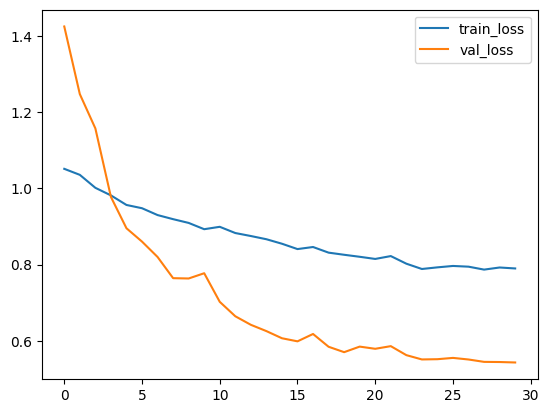

In [49]:
plt.plot(hist.history['loss'], label='train_loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

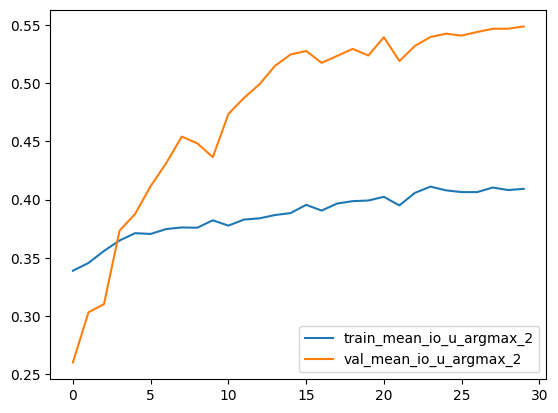

In [52]:
plt.plot(hist.history['mean_io_u_argmax_2'], label='train_mean_io_u_argmax_2')
plt.plot(hist.history['val_mean_io_u_argmax_2'], label='val_mean_io_u_argmax_2')
plt.legend()
plt.show()

In [58]:
# Supposons que ton modèle s'appelle `model`
predictions = model.predict(test_ds)  # Shape: (N, H, W, nb_classes)

# On extrait les classes prédites (par pixel)
predicted_masks = np.argmax(predictions, axis=-1)

48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 302ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


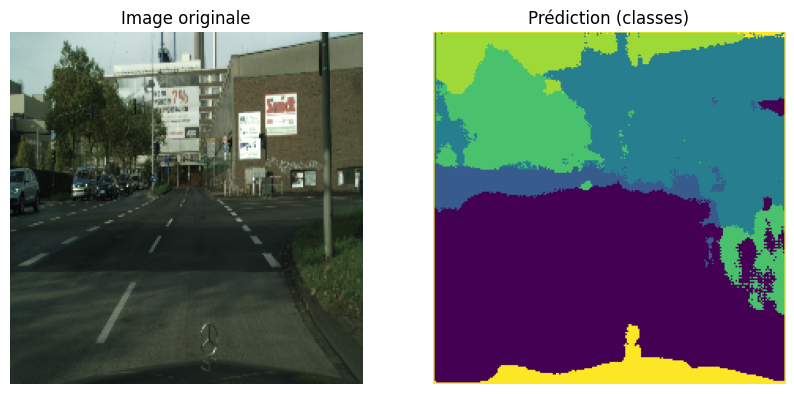

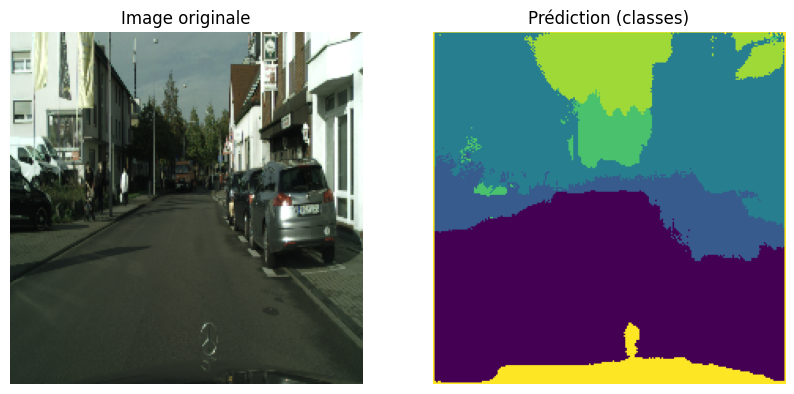

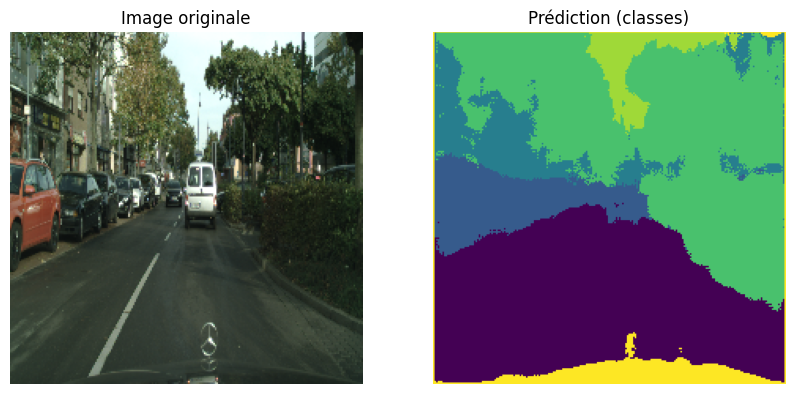

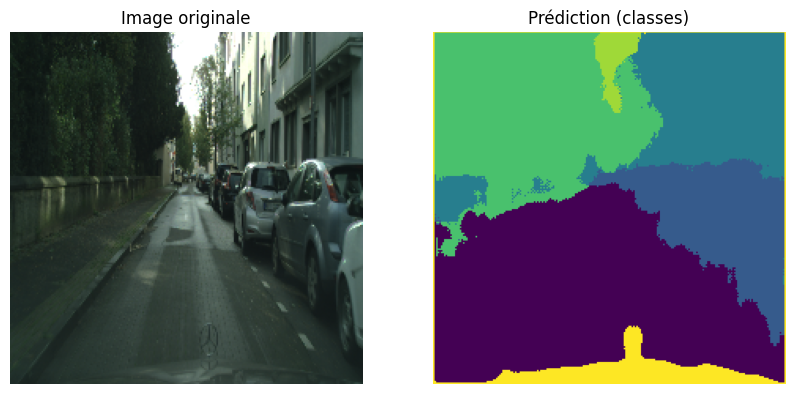

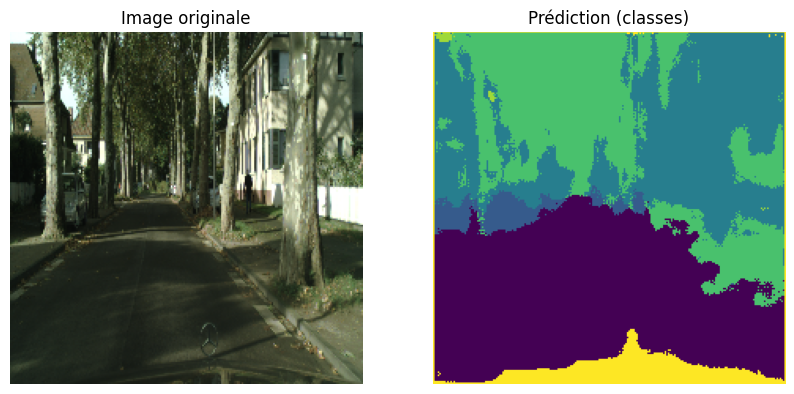

In [62]:
def display_prediction(image, pred_mask):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Image originale")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(pred_mask, cmap="viridis")  # tu peux aussi utiliser une palette custom
    plt.title("Prédiction (classes)")
    plt.axis("off")

    plt.show()

for batch, masks in test_ds.take(1):  # prendre un seul batch (32 images)
    preds = model.predict(batch)  # prédictions sur les 32 images
    masks = np.argmax(preds, axis=-1)  # (32, H, W)
    batch_np = batch.numpy()  # convertir les images pour affichage

    for i in range(5):  # afficher les 5 premières
        display_prediction(batch_np[i], masks[i])

In [56]:
print(f"Test results: {dict(zip(model.metrics_names, res))}")

Test results: {'loss': 3.2764742374420166, 'compile_metrics': 0.008411156944930553}


In [ ]:
def visualize_predictions(model, batch=None):
    """Visualiser des prédictions de segmentation"""
    print("\n" + "="*60)
    print("VISUALISATION DES PRÉDICTIONS")
    print("="*60)

    # Faire des prédictions
    predictions = model.predict(test_images, verbose=0)
    pred_masks = tf.argmax(predictions, axis=-1)

    # Visualiser
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    for i in range(2):
        # Image d'entrée (normalisée pour affichage)
        img_display = (test_images[i] - tf.reduce_min(test_images[i])) / (
            tf.reduce_max(test_images[i]) - tf.reduce_min(test_images[i])
        )
        axes[i, 0].imshow(img_display)
        axes[i, 0].set_title(f'Image {i+1}')
        axes[i, 0].axis('off')

        # Masque vérité terrain
        axes[i, 1].imshow(test_masks[i], cmap='tab10', vmin=0, vmax=NUM_CLASSES-1)
        axes[i, 1].set_title(f'Vérité terrain {i+1}')
        axes[i, 1].axis('off')

        # Prédiction
        axes[i, 2].imshow(pred_masks[i], cmap='tab10', vmin=0, vmax=NUM_CLASSES-1)
        axes[i, 2].set_title(f'Prédiction {i+1}')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.savefig('predictions_demo.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("Visualisation sauvegardée dans 'predictions_demo.png'")

## VGG16-UNet

In [38]:
def ASPP(x, filters):
    dims = x.shape
    y1 = layers.Conv2D(filters,1,padding='same',activation='relu')(x)
    y2 = layers.Conv2D(filters,3,padding='same', activation='relu',
                       dilation_rate=6)(x)
    y3 = layers.Conv2D(filters,3,padding='same', activation='relu',
                       dilation_rate=12)(x)
    y4 = layers.Conv2D(filters,3,padding='same', activation='relu',
                       dilation_rate=18)(x)
    y5 = layers.GlobalAveragePooling2D()(x)
    y5 = layers.Reshape((1,1,dims[-1]))(y5)
    y5 = layers.Conv2D(filters,1,padding='same',activation='relu')(y5)
    y5 = layers.UpSampling2D((dims[1], dims[2]), interpolation='bilinear')(y5)
    return layers.Concatenate()([y1,y2,y3,y4,y5])

def deeplabv3plus_resnet50(input_shape=(224,224,3), num_classes=8):
    base = tf.keras.applications.ResNet50(
        input_shape=input_shape, include_top=False, weights='imagenet')

    # encoder features
    low_level = base.get_layer("conv2_block3_out").output  # 64×64
    x = base.get_layer("conv4_block6_out").output          # 16×16

    # ASPP
    x = ASPP(x, 256)
    x = layers.UpSampling2D((4,4), interpolation='bilinear')(x)  # → 64×64

    # merge low-level
    low = layers.Conv2D(48,1,padding='same',activation='relu')(low_level)
    x = layers.Concatenate()([x, low])
    x = layers.Conv2D(256,3,padding='same',activation='relu')(x)
    x = layers.Conv2D(256,3,padding='same',activation='relu')(x)

    # final upsample to 256×256
    x = layers.UpSampling2D((4,4), interpolation='bilinear')(x)
    outputs = layers.Conv2D(num_classes,1,activation='softmax')(x)

    return Model(base.input, outputs)


In [39]:
end_time = time.time()
print(f"Execution time={end_time-init_time} seconds")

Execution time=27.714841604232788 seconds
